## Convolutional Neural Networks
### Notebook Author: Nirupam Purushothama

This is a practice notebook for CNN architectures. All code is from the reference book.

<b>Reference book:</b> Hands-on Machine Learning with Scikit-Learn and TensorFlow - Aurelien Geron

<b>Note:</b> Requires 4GB RAM.

In [1]:
import numpy as np
from sklearn.datasets import load_sample_images, load_sample_image

In [2]:
import tensorflow as tf
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from io import open

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

### 1. Convolutional Layer

Simple example of what happens during the convolution phase. Take a static filter of weights and then apply to the image and see.

In [18]:
# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

#### Explaining the detail below
- image representation - 3D tensor - [height, width, channels]
- Mini-batch - 4D tensor - [mini-batch-size, height, width, channels]
- weights (of a convolutional layer] - 4D tensor - [height, width, present-layer-feature-map-index, previous-layer-feature-map-index]

In [39]:
# Create 2 filters
filters = np.zeros(shape=(7,7,channels,2), dtype=np.float32)
filters[:,3,:,0] = 1 # Vertical line
filters[3,:,:,1] = 1 # Horizontal line

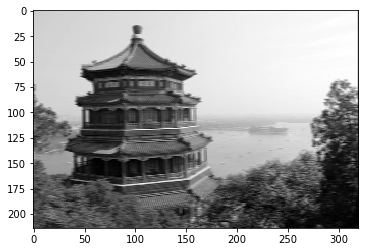

In [40]:
# Create a graph with input X plus a convolutional layer applying the 2 filters

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})
    
plt.imshow(output[0,:, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

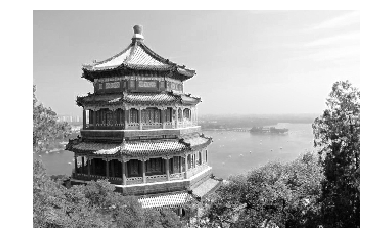

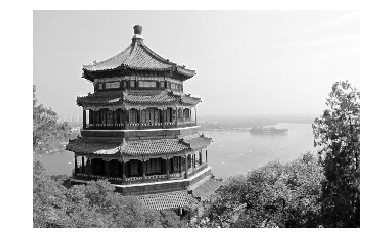

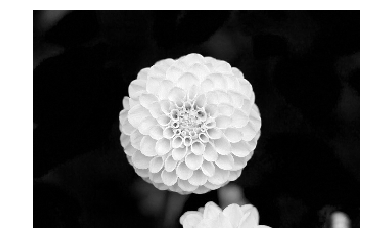

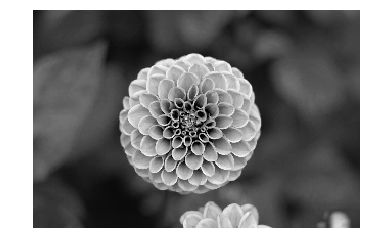

In [48]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

### 2. Pooling Layer
Check to see what happens when you the pass the image through pooling instead of convoluting it with a filter

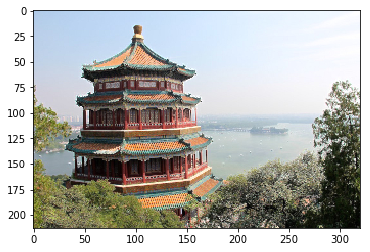

In [55]:
# Create a graph with input X plus a max pooling layer
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})
    
plt.imshow(output[0].astype(np.uint8))
plt.show()

### 3. Exercise - Build CNN for MNIST

Code taken from [Handson - Github](https://github.com/ageron/handson-ml/)

Building a CNN with - 2 convolutional layers followed by one pooling layer
* convolutional layer 1 (upper-most) - kernel-size: 3 x 3, feature-maps: 32, Stride: 1, Padding: SAME
* convolutional layer 2 (lower-most) - kernel-size: 3 x 3, feature-maps: 64, Stride: 2, Padding: SAME
* Pooling layer - feature-maps: 64 (same as that of conv2) [Each pooling layer works on the corresponding layer in the previous level]

Some observations: Input-layer has only 1 channel, it is blown-up into 32 layers, which is then blown-up to 64 but the second layer has a higher stride length so condenses the information gathered in layer-1

MNIST - Input characteristics
* Height: 28px, Width: 28px
* Channels: 1
* Hence: Total inputs = height x width [This needs to be reshaped]

In [5]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_padding = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_padding = "SAME"

# As discussed in the book, pooling typically applies on every map individually and hence maps remain same
pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize, 
                         strides = conv1_stride, padding = conv1_padding, activation = tf.nn.relu, name="conv1")

conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize, 
                         strides = conv2_stride, padding = conv2_padding, activation = tf.nn.relu, name="conv2")

# Two types of poolings are possible max and mean. Choosing max here (i.e. chooses the max in the layer it maps to)
with tf.name_scope("pool3"):
    # ksize is the size of the window for each dimension of the input tensor [batch-size, height, width, channels]
    # inputs and channels = 1 (because we are not taking the average over multiple batches & channels )
    # Same holds for strides [batch-size, height, width, channels]. Currently batch-size and channels are 1 
    # strides over batches / channels is not supported
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])
    
    # Only Open question is how did they figure out that the reshape size is pool3_fmaps * 7 * 7
    
# Now feed the previous layer into a regular dense Deep Neural Network with 64 neurons
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    
# Take that output and then map it to outputs. Compute the softmax probabilities from the logits that are computed
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

# Compute the cross entropy using the logits and then attempt to reduce the loss (just as in MNIST_DNN)
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    
    # This is the step to run 
    training_op = optimizer.minimize(loss)

# Check the evaluated classes and find the accuracy
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# Initialize the network and save it
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [6]:
# Load the inputs and start training.

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:] # split to validation set and training set
y_valid, y_train = y_train[:5000], y_train[5000:] # split to validation set and training set

In [7]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [8]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Last batch accuracy: 0.99 Test accuracy: 0.9777
1 Last batch accuracy: 0.97 Test accuracy: 0.984
2 Last batch accuracy: 0.98 Test accuracy: 0.9792
3 Last batch accuracy: 0.98 Test accuracy: 0.9882
4 Last batch accuracy: 0.99 Test accuracy: 0.9882
5 Last batch accuracy: 1.0 Test accuracy: 0.9877
6 Last batch accuracy: 1.0 Test accuracy: 0.9885
7 Last batch accuracy: 1.0 Test accuracy: 0.9906
8 Last batch accuracy: 1.0 Test accuracy: 0.9894
9 Last batch accuracy: 1.0 Test accuracy: 0.9892
